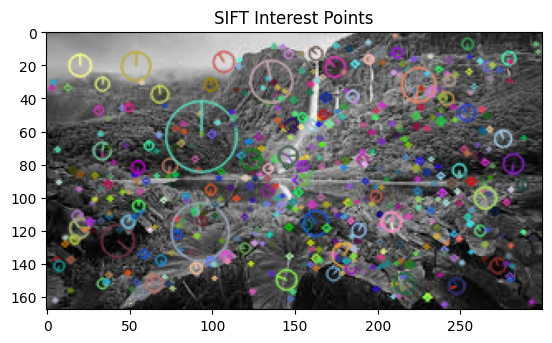

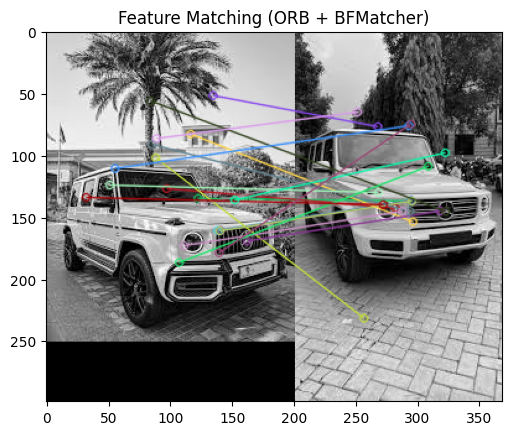

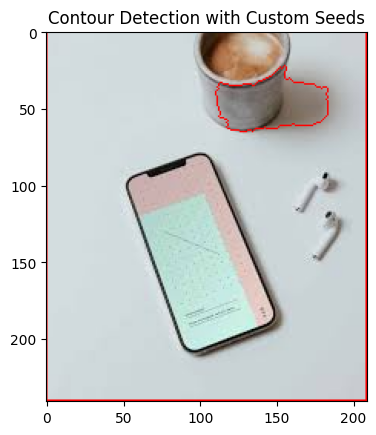

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def interest_point_detection(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)

    image_sift = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    plt.imshow(image_sift, cmap='gray')
    plt.title("SIFT Interest Points")
    plt.show()
    # return keypoints, descriptors

def feature_matching(image1_path, image2_path):
    img1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)

    orb = cv2.ORB_create()
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)

    img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:20], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    plt.imshow(img_matches)
    plt.title("Feature Matching (ORB + BFMatcher)")
    plt.show()

def contour_detection(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    markers = cv2.connectedComponents(sure_fg)[1]
    markers += 1
    markers[unknown == 255] = 0

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.watershed(img, markers)
    img[markers == -1] = [255, 0, 0]

    plt.imshow(img)
    plt.title("Contour Detection with Custom Seeds")
    plt.show()

# Example Usage
interest_point_detection('/content/nature.jpeg')
feature_matching('img1.jpeg', 'img2.jpeg')
contour_detection('images.jpeg')


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 68s 142ms/step - loss: 0.1180 - val_loss: 0.1140
Epoch 2/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 81s 140ms/step - loss: 0.1117 - val_loss: 0.1140
Epoch 3/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 81s 140ms/step - loss: 0.1117 - val_loss: 0.1140
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step


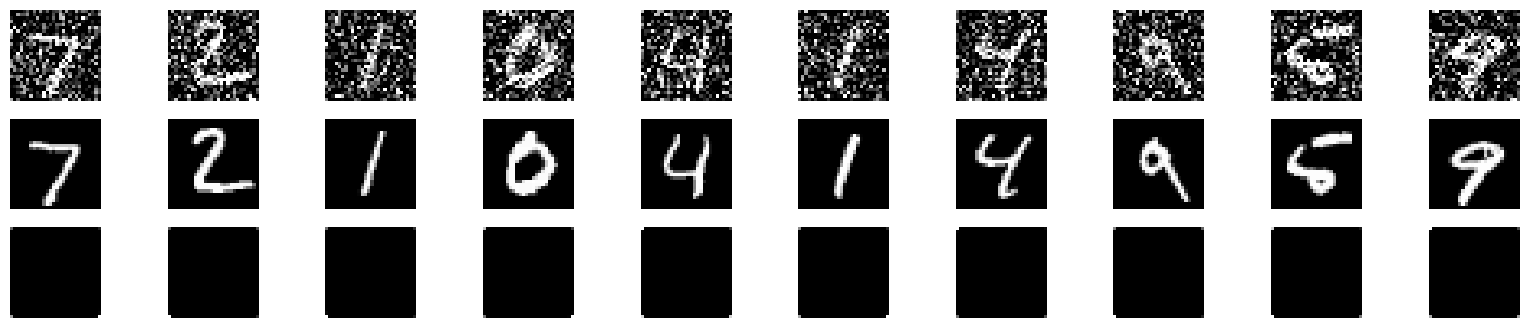

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

def load_and_preprocess_data():
    (x_train, _), (x_test, _) = mnist.load_data()
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    x_train = np.expand_dims(x_train, axis=-1)
    x_test = np.expand_dims(x_test, axis=-1)
    return x_train, x_test

def add_noise(images):
    noise_factor = 0.5
    noisy_images = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    return np.clip(noisy_images, 0., 1.)

def build_autoencoder():
    input_img = Input(shape=(28, 28, 1))

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

def train_autoencoder(autoencoder, x_train, x_test):
    noisy_x_train = add_noise(x_train)
    noisy_x_test = add_noise(x_test)

    autoencoder.fit(noisy_x_train, x_train, epochs=3, batch_size=128, validation_data=(noisy_x_test, x_test))
    return noisy_x_test

def evaluate_model(autoencoder, x_test, noisy_x_test):
    decoded_imgs = autoencoder.predict(noisy_x_test)

    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(noisy_x_test[i].reshape(28, 28), cmap='gray')
        ax.axis('off')

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
        ax.axis('off')

        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
        ax.axis('off')
    plt.show()

# Load and preprocess data
x_train, x_test = load_and_preprocess_data()

# Build autoencoder
autoencoder = build_autoencoder()

# Train model
noisy_x_test = train_autoencoder(autoencoder, x_train, x_test)

# Evaluate model
evaluate_model(autoencoder, x_test, noisy_x_test)